# Feature Weight of Gradient Boosting Classifier Models
---
Taking the trends from the straify included methods, the best parameters from the grid search will be ranto determin the weights the models placed on each of the features.
* Inspection of the feature weights could reavel the features that are driving the model
* Features with the highest/most influencial weights could be related to wine compentents that are important to consumers in in addition to winemakers

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
# The 'ID' feature is already dropped from cleaning notebook

# Open all source files as a pd dataframe
# This dataset will be used to train the gradient boosted model
orig_train = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/train.csv')

#This dataset will be used to evaluate again the Kaggle compitition entry submission
orig_test = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/test.csv')

# Addition datasets to explore the GradBoost model on actual wine data
red_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/red_white_data_noID.csv')
white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/white_data_noID.csv')
red_white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/red_white_data_noID.csv')
trainable_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/trainable_data_noID.csv')

# Drop 'ID' columns
orig_test = orig_test.drop(columns='Id')
orig_train = orig_train.drop(columns='Id')

# Create a place to save any generated files
gb_txt_output_path = os.path.join('../grad boost output','classification reports')
gb_png_output_path = os.path.join('../grad boost output','feature weight plots')
os.makedirs(gb_txt_output_path, exist_ok = True)
os.makedirs( gb_png_output_path, exist_ok = True)

In [5]:
def split(dataset):

    # Split the data into training and testing sets
    X_train = dataset.drop('quality', axis=1)
    y_train = dataset['quality'].copy()
    X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                       y_train, 
                                                       test_size = 0.2, 
                                                       random_state = 42) #because it is the answer :)
    return X_train, X_val, y_train, y_val

def stratify_split(dataset):

    # Split the data into training and testing sets
    X_train = dataset.drop('quality', axis=1)
    y_train = dataset['quality'].copy()
    quality_rating = list(y_train)
    X_train_st, X_val_st, y_train_st, y_val_st = train_test_split(X_train, 
                                                      y_train, 
                                                      stratify= quality_rating,
                                                      test_size = 0.2, 
                                                      random_state = 42) #because it is the answer :)
    return X_train_st, X_val_st, y_train_st, y_val_st

In [6]:
model_param = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/gb_model_comparo.csv')

In [49]:
#--------------------------------
#
# Define the dataset to use to on the model parameter grid search
#
dataset = trainable_data
#
#
# Provide name of data used for filename and plot titles
#--------------------------------
data = 'Combined Trainable'
param_found_dataset = 'Original'
#--------------------------------

In [43]:
## Change the name in the cell above!!!!

In [44]:

X_train, X_val, y_train, y_val = split(dataset)
X_train_st, X_val_st, y_train_st, y_val_st = stratify_split(dataset)

features = list(X_val[:0])

# Create df to hold the feature weights determined by the model's parameters
features_df = pd.DataFrame({'features' : list(X_val[:0])})

In [45]:
# Initialize an empty DataFrame to store feature importances
feature_weight = pd.DataFrame()
feature_weight['features'] = list(X_val[:0])

for index, row in model_param.iterrows():
    stratification = row['stratification']
    kappa = row['kappa']
    
    if stratification in ['none', 'skf']:
        # Use X_train, y_train, and X_val for 'none' and 'skf'
        X_train, X_val, y_train, y_val  = X_train, X_val, y_train, y_val
        
        # Create and fit the GradientBoostingClassifier
        model = GradientBoostingClassifier(n_estimators=row['estimators'], learning_rate=row['learning_rate'], max_depth=row['max_depth'])
        model.fit(X_train, y_train)
        
        # Predict and get feature importances
        y_pred = model.predict(X_val)
        importances = model.feature_importances_
        
    elif stratification in ['stratify', 'st_skf']:
        # Use X_train_st, y_train_st, and X_val_st for 'stratify' and 'st_skf'
        X_train_st, y_train_st, X_val_st, y_val_st = X_train_st, y_train_st, X_val_st, y_val_st
        
        # Create and fit the GradientBoostingClassifier
        model = GradientBoostingClassifier(n_estimators=row['estimators'], learning_rate=row['learning_rate'], max_depth=row['max_depth'])
        model.fit(X_train_st, y_train_st)
        
        # Predict and get feature importances
        y_pred = model.predict(X_val_st)
        importances = model.feature_importances_

    # Create a new column for this iteration's feature importances
    feature_weight[f'{stratification}, kappa: {kappa:.4f}'] = importances
    

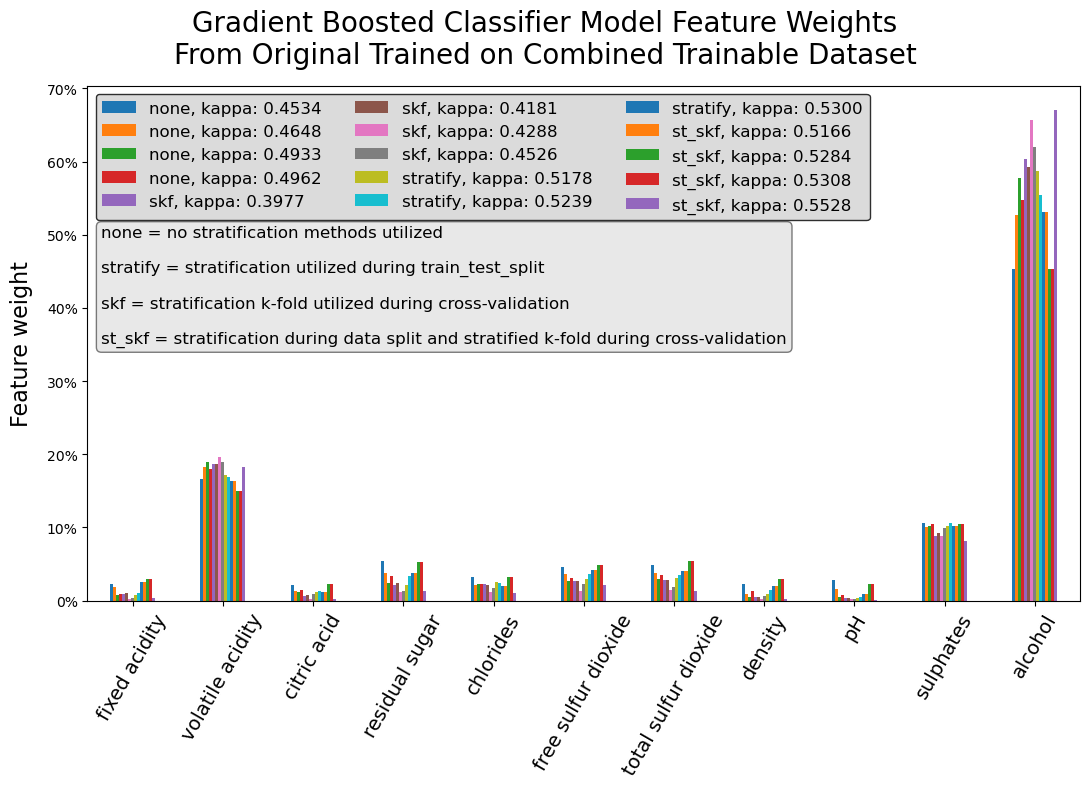

In [50]:

# Create list of features for x-axis
features = [col for col in X_val.columns]

# Create the figure and gridspec
fig_width = len(features) * 1.0
fig, ax = plt.subplots(figsize=(fig_width, 8))
# grid_spec = GridSpec(3, 1, figure=fig, width_ratios = [1], height_ratios=[1,2,10])

# Plot bar chart of feature weights
feature_weight.plot.bar(ax=ax)

# Set x-axis labels using the index (which is now 'features' column)
ax.set_xticks(range(len(features)))
ax.set_xticklabels(features, rotation=60, fontsize=14, ha = 'center')

# Format y-axis labels as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

# Set labels and title
plt.ylabel('Feature weight', fontsize=16, labelpad = 10)
fig.suptitle(f'Gradient Boosted Classifier Model Feature Weights\nFrom {param_found_dataset} Trained on {data} Dataset', fontsize = 20)
ax.legend(loc='upper left', ncol=3, fontsize = 12, facecolor = 'lightgrey', edgecolor='black')

# Define the position and size of the text box
text_box_params = dict(boxstyle='round', facecolor='lightgrey', edgecolor='black', alpha=0.5)
# Add the text below the legend
text = (
    "none = no stratification methods utilized\n\n"
    "stratify = stratification utilized during train_test_split\n\n"
    "skf = stratification k-fold utilized during cross-validation\n\n"
    "st_skf = stratification during data split and stratified k-fold during cross-validation"
)
plt.text(0.014, .50, text, transform=ax.transAxes, fontsize=12, bbox = text_box_params)
plt.tight_layout()

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb feature weights from {data} data from {param_found_dataset} search.png"
plt.savefig(output_filename)
plt.show()

plt.show()

# Compare Feature Distribution within Dataset
Create box plots to visualize the the range for each feature

In [47]:
acidic = dataset[['fixed acidity', 'volatile acidity', 'citric acid','pH']]
sulfur = dataset[['free sulfur dioxide', 'total sulfur dioxide','sulphates']]
texture = dataset[['residual sugar','chlorides','density','alcohol']]
box_data = dataset.drop(columns = 'quality')
box_data = box_data.rename(columns={'free sulfur dioxide':'free sulfur','total sulfur dioxide':'total sulfur'})
box_data_no_SO2 = box_data.copy()
box_data_no_SO2[['total sulfur', 'free sulfur']]=0

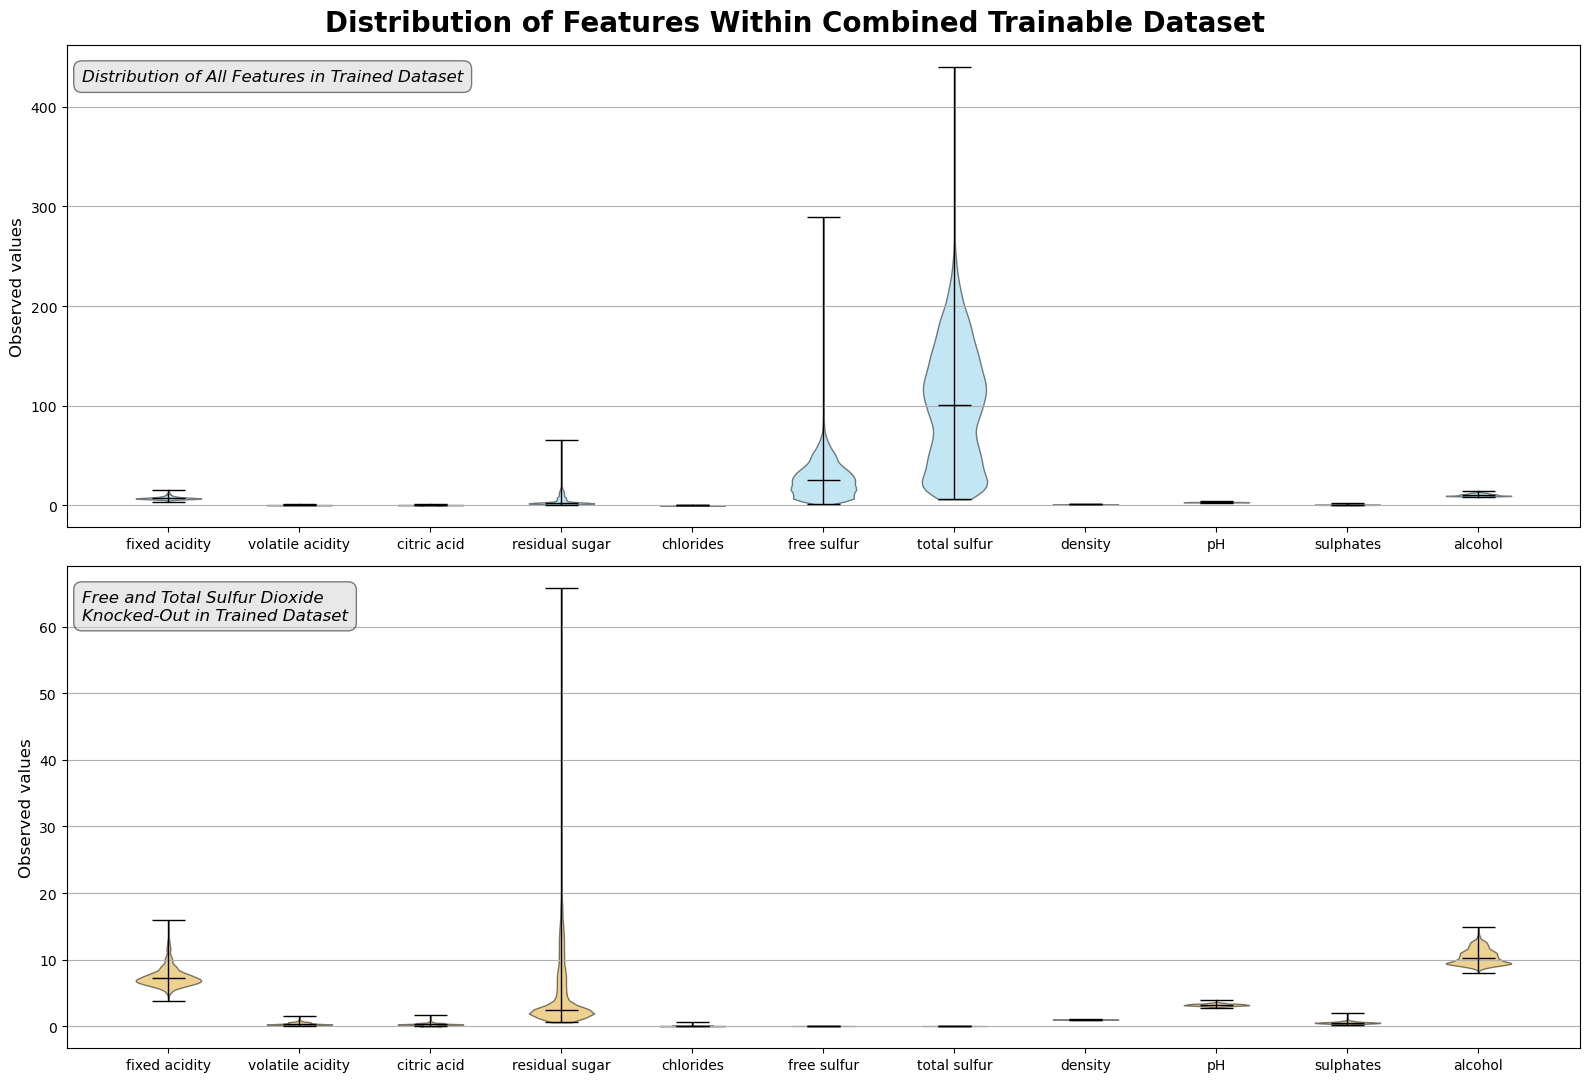

In [51]:
# Customizing violin plots: https://python-charts.com/distribution/violin-plot-matplotlib/

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 11))

labels = box_data.columns

# plot violin plot
violin_1 = axs[0].violinplot(box_data,
                  showmeans=False,
                  showmedians=True)
for pc in violin_1['bodies']:
    pc.set_facecolor('skyblue')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
for partname in ('cbars','cmins','cmaxes','cmedians'): # include 'cmeans' if showmeans=True 
    vp = violin_1[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
axs[0].text(0.01, 0.95, 'Distribution of All Features in Trained Dataset',
        color='black', style = 'italic', fontsize=12,
        transform=axs[0].transAxes, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))


# plot no total sulfur dioxide violin plot
violin_2 = axs[1].violinplot(box_data_no_SO2,
                  showmeans=False,
                  showmedians=True)
for pc in violin_2['bodies']:
    pc.set_facecolor('goldenrod')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
for partname in ('cbars','cmins','cmaxes','cmedians'): # include 'cmeans' if showmeans=True 
    vp = violin_2[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
axs[1].text(0.01, 0.95,'Free and Total Sulfur Dioxide\nKnocked-Out in Trained Dataset',
        color='black', style = 'italic', fontsize=12,
        transform = axs[1].transAxes, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))

# adding horizontal grid lines
for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticklabels(box_data.columns, fontsize = 10)
    # ax.set_xticks(labels, rotation = 75)
    ax.set_xticks([y + 1 for y in range(len(list(box_data[:0])))],
                  labels=box_data.columns)
    
    ax.set_ylabel('Observed values', fontsize = 12)

fig.suptitle(f"Distribution of Features Within {data} Dataset", fontsize = 20,fontweight = 'bold')
plt.tight_layout()

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb feature distribution from {data} data from {param_found_dataset} search.png"
plt.savefig(output_filename)
plt.show()

plt.show()